In [7]:
import os
HOME = os.getcwd()

Download Video

In [8]:
!pip install -q gdown
%cd {HOME}
# !gdown '1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-'
!gdown '16VGKdSgAnvh2oiE6n1IpoFe_ro1CttMV'

/content
Downloading...
From (original): https://drive.google.com/uc?id=16VGKdSgAnvh2oiE6n1IpoFe_ro1CttMV
From (redirected): https://drive.google.com/uc?id=16VGKdSgAnvh2oiE6n1IpoFe_ro1CttMV&confirm=t&uuid=2d33f803-3e50-4d80-8d0d-1a7da2288958
To: /content/4K Road traffic video for object detection and tracking - free download now!.mp4
100% 144M/144M [00:06<00:00, 23.6MB/s]


In [9]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

Install YOLOv8

In [10]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.8/78.2 GB disk)


Install Roboflow Supervision

In [11]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.22.0


Load pre-trained YOLOv8 model

In [12]:
MODEL = "yolov8x.pt"

In [13]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 257MB/s]


YOLOv8x summary (fused): 268 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


Predict and annotate single frame

In [14]:
CLASS_NAMES_DICT = model.model.names
selected_classes = [2, 3, 5, 7]

In [15]:
import supervision as sv
import numpy as np
import cv2

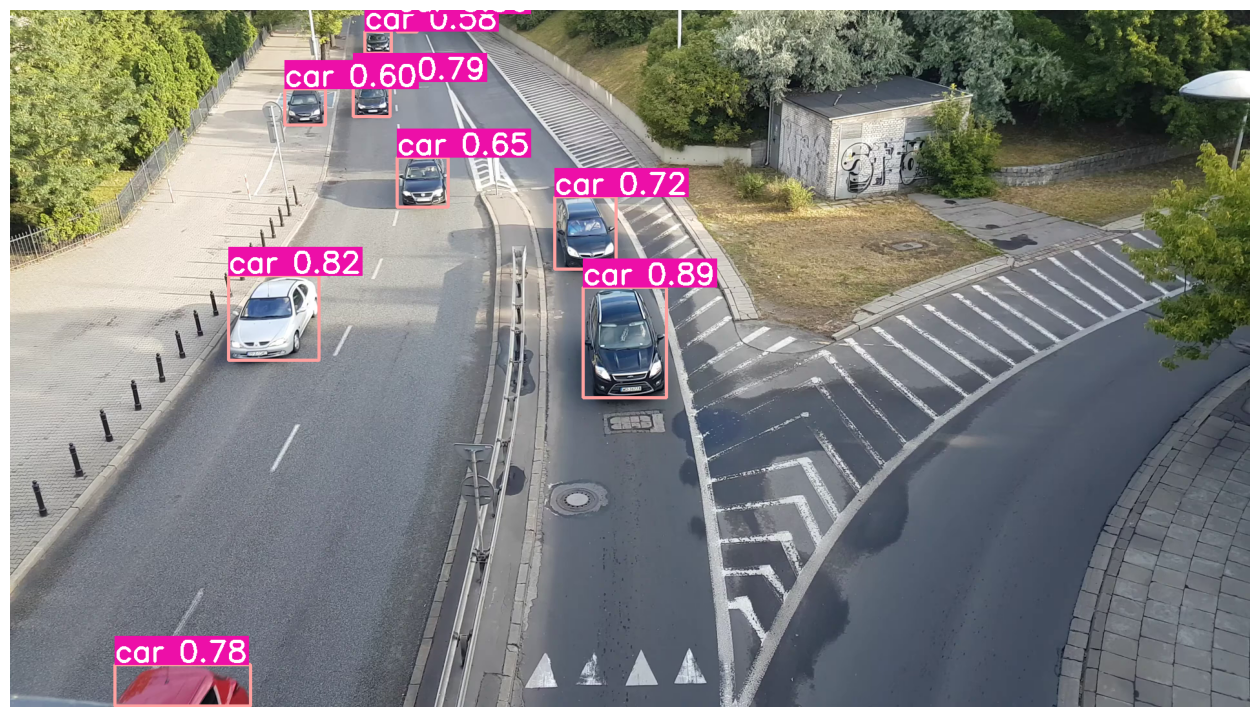

In [16]:
# Generador para los frames de video
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
box_annotator = sv.BoxAnnotator(thickness=4)  # Solo thickness, ya que otros parámetros no son soportados

# Obtener el primer frame
iterator = iter(generator)
frame = next(iterator)

# Ejecutar el modelo en el frame
results = model(frame, verbose=False)[0]

# Convertir los resultados en detecciones
detections = sv.Detections.from_ultralytics(results)
detections = detections[np.isin(detections.class_id, selected_classes)]

# Definir una función para asignar colores únicos a cada clase
def get_class_color(class_id):
    np.random.seed(class_id)  # Para asegurar consistencia en el color de cada clase
    return tuple(np.random.randint(0, 256, size=3).tolist())

# Crear los labels para las detecciones
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# Anotar el frame
annotated_frame = box_annotator.annotate(scene=frame, detections=detections)

# Ahora, dibujar manualmente los labels con OpenCV, usando el mismo color que la caja
for (box, label, class_id) in zip(detections.xyxy, labels, detections.class_id):
    x1, y1, x2, y2 = map(int, box)  # Coordenadas de la caja

    # Obtener el color para esta clase
    color = get_class_color(class_id)

    # Dibujar el fondo del label
    (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 3)  # Escala de fuente de 1.5, grosor de 3
    cv2.rectangle(annotated_frame, (x1, y1 - h - 10), (x1 + w, y1), color=color, thickness=-1)

    # Dibujar el texto del label (con color blanco para contraste)
    cv2.putText(annotated_frame, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)

# Mostrar el frame anotado
%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))




Predict and annotate whole video

In [17]:
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result-with-counter.mp4"

In [18]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=30, total_frames=9184)

In [19]:
import cv2
import numpy as np
import supervision as sv

# Crear instancia de BYTETracker
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)

# Crear instancia de VideoInfo
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Crear generador de frames
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Crear instancia de LineZone
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# Crear instancia de BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)

# Crear instancia de TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# Crear instancia de LineZoneAnnotator
line_zone_annotator = sv.LineZoneAnnotator(thickness=4)

# Función para obtener colores únicos por clase
def get_class_color(class_id):
    np.random.seed(class_id)  # Asegura consistencia de color para cada clase
    return tuple(np.random.randint(0, 256, size=3).tolist())

# Definir función de callback para procesamiento de video
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Predicción del modelo en un solo frame y conversión a detecciones de supervision
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    # Considerar solo las clases seleccionadas
    detections = detections[np.isin(detections.class_id, selected_classes)]

    # Seguimiento de detecciones
    detections = byte_tracker.update_with_detections(detections)

    # Crear labels y asignar color
    labels = []
    for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id):
        label = f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        labels.append(label)

    # Anotar trazas de los objetos
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )

    # Anotar cajas y labels
    for (box, label, class_id) in zip(detections.xyxy, labels, detections.class_id):
        x1, y1, x2, y2 = map(int, box)  # Coordenadas de la caja

        # Obtener el color para esta clase
        color = get_class_color(class_id)

        # Dibujar la caja del objeto
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color=color, thickness=4)

        # Dibujar el fondo del label
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 3)
        cv2.rectangle(annotated_frame, (x1, y1 - h - 10), (x1 + w, y1), color=color, thickness=-1)

        # Dibujar el texto del label
        cv2.putText(annotated_frame, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)

    # Actualizar el contador de línea
    line_zone.trigger(detections)

    # Devolver el frame con las cajas y líneas anotadas
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# Procesar todo el video
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)


SupervisionWarnings: `track_buffer` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'lost_track_buffer' instead.
SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.
SupervisionWarnings: `match_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'minimum_matching_threshold' instead.
